In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [82]:
train = pd.read_csv("data/cleaned_train.csv")
test = pd.read_csv("data/cleaned_test.csv")

In [83]:
train.head(10)

,gdp,population,total_generation,co2
0,4.156140e+12,195653775.0,297.739381,3399.547
1,4.428300e+12,198265397.0,297.739381,3571.421
2,4.538980e+12,200699913.0,297.739381,3705.461
3,4.754930e+12,203011021.0,297.739381,3840.919
4,4.903770e+12,205300032.0,297.739381,4035.145
5,4.912640e+12,207796339.0,297.739381,4339.686
6,5.065680e+12,210426424.0,297.739381,4365.465
7,5.334300e+12,212842574.0,297.739381,4573.015
8,5.637200e+12,215006548.0,298.202393,4785.434
9,5.621370e+12,217076474.0,327.688904,4621.419


In [84]:
y = ["co2"]
X_train, y_train = train.drop(columns = y), train[y]
X_test, y_test = test.drop(columns = y), test[y]

**Determining the differencing needed to make CO_2 (outcome) stationary**

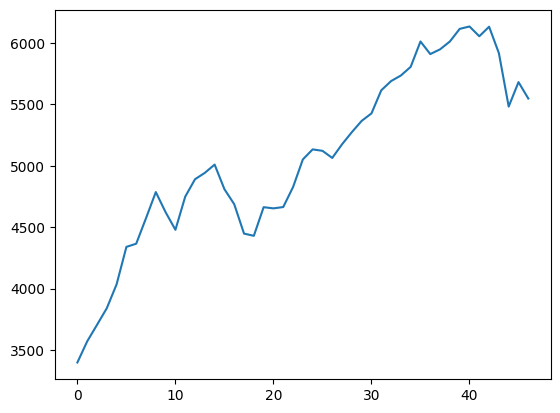

In [85]:
y_train["co2"].plot()
plt.show()

The initial CO_2 is not stationary. This is expected as the CO_2 usage should have increased over the last 60 years.

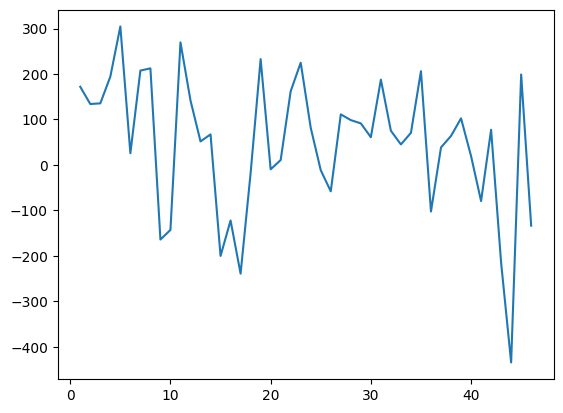

In [86]:
y_train["co2"].diff().plot()
plt.show()

This seems to be stationary, as the mean is constant near 0 and the variance appears to be homoscedastic. We will check with Ay_train test.

In [87]:
y = y_train["co2"].diff().dropna()
res = adfuller(y, maxlag=None, regression='c')
stat, pval, usedlag, nobs, crit, icbest = res

print(f"ADF statistic: {res[0]:.3f}")
print(f"p-value: {res[1]:.4f}")

ADF statistic: -5.400
p-value: 0.0000


Since p-value < 0.05, the differenced series is stationary, so d = 1

**Removing multicollinearity in the features**

In [88]:
X = X_train[["gdp", "population", "total_generation"]]
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

           features        VIF
0               gdp  64.904578
1        population  14.481384
2  total_generation   2.716329


There is excessive multicollinearity between gdp and population.

In [89]:
X = X_train[["population", "total_generation"]]
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

           features         VIF
0        population  121.836497
1  total_generation  121.836497


In [90]:
X = X_train[["gdp", "total_generation"]]
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

           features       VIF
0               gdp  10.07407
1  total_generation  10.07407


However by removing either, the remaining feature becomes significantly correlated with total_generation as well. We will keep total_generation only to avoid multicollinearity.

In [91]:
X_train_final = X_train[["total_generation"]]

**Determining p and q for the ARIMAX Model**

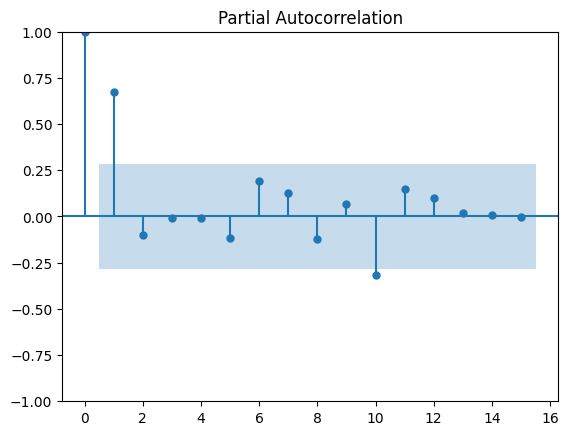

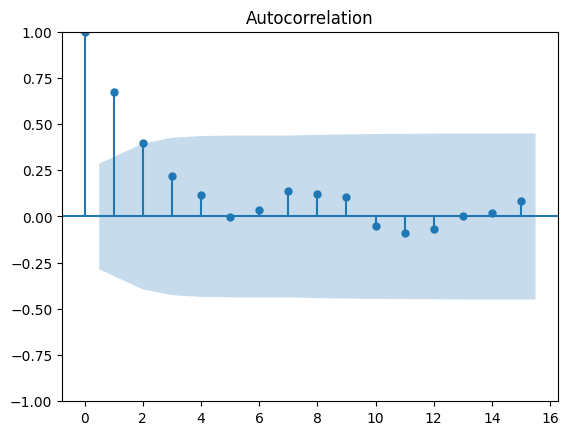

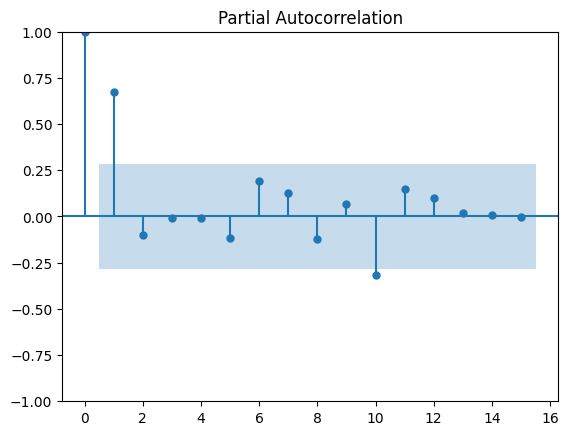

In [95]:
y = y_train['co2']
X = X_train_final[["total_generation"]]

res = sm.OLS(y, sm.add_constant(X)).fit().resid

sm.graphics.tsa.plot_acf(res, lags=15)
sm.graphics.tsa.plot_pacf(res, lags=15)

As shown in the plots, PACF cuts off at lag = ... and ACF slowly trails off. That means p = ... and q = 0

**Fitting the model**

In [96]:
y = y_train['co2']
X = X_train_final[["total_generation"]]

model = SARIMAX(y, exog = X, order = (1, 1, 0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                   47
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -295.951
Date:                Thu, 31 Jul 2025   AIC                            597.901
Time:                        17:56:33   BIC                            603.387
Sample:                             0   HQIC                           599.956
                                 - 47                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
total_generation    -1.0313      1.269     -0.812      0.417      -3.519       1.456
ar.L1                0.2574      0.115      2.246      0.025       0.033       0.482
sigma2            2.272e+04 

**Assessing Performance**

In [113]:
fc = res.get_forecast(steps=len(y_test), exog=X_test[["total_generation"]])
y_pred = fc.predicted_mean
pred_int = fc.conf_int()

In [114]:
pred_int

,lower co2,upper co2
47,5010.726581,5601.570155
48,4822.678522,5771.913407
49,4680.057519,5909.976978
50,4560.446449,6023.396067
51,4388.239897,6053.129662
52,4212.125323,6057.269254
53,4102.574104,6111.934151
54,3997.805961,6158.956090
55,3863.625081,6166.586237
56,3786.398748,6222.932136


In [111]:
import numpy as np
from sklearn.metrics import mean_absolute_error

mae  = mean_absolute_error(y_test, y_pred)

eps = 1e-8
y_true = y_test.values
y_hat  = y_pred.values
mape = np.mean(np.abs((y_true - y_hat) / (np.abs(y_true) + eps))) * 100

print(f"MAE : {mae:,.3f}")
print(f"MAPE: {mape:,.2f}%")

MAE : 136.842
RMSE: 27,925.513
MAPE: 4.16%


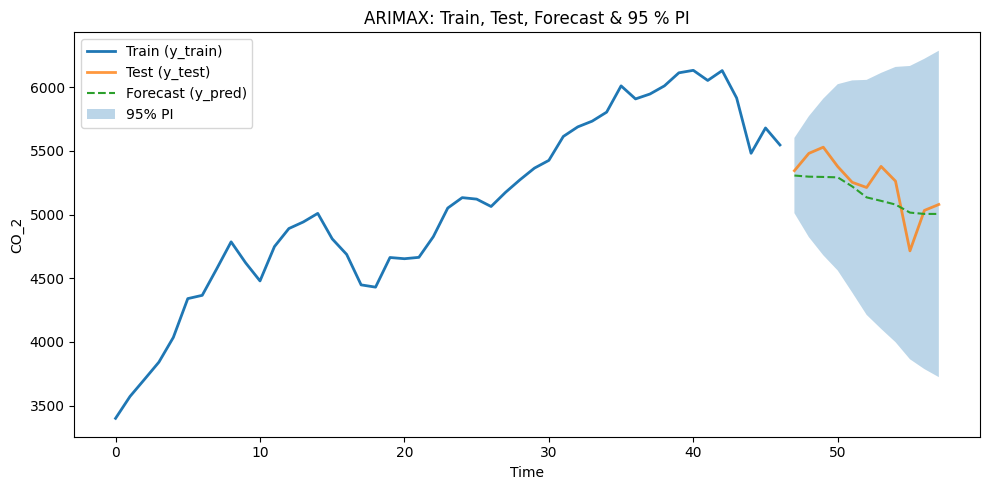

In [127]:
y_train = y_train.copy()
y_test = y_test.copy()

y_train.index = np.arange(len(y_train))
y_test.index = np.arange(len(y_train), len(y_train) + len(y_test))

y_pred.index = y_test.index
pred_int.index = y_test.index

plt.figure(figsize=(10, 5))

plt.plot(y_train, label='Train (y_train)', linewidth=2)
plt.plot(y_test, label='Test (y_test)', linewidth=2, alpha=0.8)
plt.plot(y_pred, label='Forecast (y_pred)', linestyle='--')

plt.fill_between(
    pred_int.index,
    pred_int.iloc[:, 0],
    pred_int.iloc[:, 1],
    alpha=0.3,
    label='95% PI'
)

plt.title("ARIMAX: Train, Test, Forecast & 95 % PI")
plt.xlabel("Time")
plt.ylabel("CO_2")
plt.legend()
plt.tight_layout()
plt.show()